In [1]:
from __future__ import print_function

import os
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy.misc import logsumexp
# Keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Input, Lambda, Wrapper, merge, concatenate
from keras.engine import InputSpec
from keras.layers.core import Dense, Dropout, Activation, Layer, Lambda, Flatten
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam
from keras.layers.advanced_activations import LeakyReLU
from keras import initializers
import tensorflow as tf

import sys
sys.path.insert(0, '../code/')
import plan_net

import random
seed = 0 #0
np.random.seed(seed=seed)
random.seed(seed)

%matplotlib inline

Using TensorFlow backend.


# Load data from numpy arrays

In [2]:
def load_data_file(data_file, num_features):
    
    data = np.load(data_file)
    
    if data.ndim == 1:
        data = data[None, :]
    
    x = data[:, :num_features]
    y = data[:, num_features:]
    
    return x, y

In [3]:
num_features = 13
x_data, y_data = load_data_file(data_file='../data/training.npy', num_features=num_features)

In [4]:
Ntr = 70000
x_data_tr = x_data[:Ntr,:]
y_data_tr = y_data[:Ntr,:]
x_data_val = x_data[Ntr:,:]
y_data_val_un = y_data[Ntr:,:]

# Load Test data

In [5]:
x_data_test, y_data_test_un = load_data_file(data_file='../data/testing.npy', num_features=num_features)

## Normalise: remove mean and divide by standard deviation

In [6]:
# Normalise
x_data_tr = (x_data_tr - x_data.mean(0))/x_data.std(0)
x_data_test = (x_data_test - x_data.mean(0))/x_data.std(0)
x_data_val = (x_data_val - x_data.mean(0))/x_data.std(0)

y_data_tr = (y_data_tr - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
y_data_test = (y_data_test_un - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
y_data_val = (y_data_val_un - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]


In [7]:
x_data_tr = np.squeeze(x_data_tr)
x_data_test = np.squeeze(x_data_test)
# x_data_te = np.squeeze(x_data_te)

## Setting up the random seed

In [8]:
np.random.seed(seed=seed)
random.seed(seed)

N_ensemble = 5  #Number of networks in ensemble (I suggest sticking with 1)

## Training

In [9]:
# Variables
samples = 20 #number of samples of posterior weight distribution in BNNs
n_iters = 10
epochs = 500
T = 100
batch_size = 512#256
lengthscale = .0001
dropout = 0.138688120021828 #0.17113892846874176 #BO
tau = 3.1047740953274015#2.915523840898378 #BO
layers = [1024,1024,1024,1024] #BO

bnn = plan_net.BNNModel_het_chol(x_data_tr, y_data_tr, layers ,
                        dropout = dropout, T=T , tau = tau, lengthscale = lengthscale,
                        train_flag = False)
# train flag is false so train method will only load weights from ./ens_folder_models
bnn.train(epochs = epochs, batch_size = batch_size, validation_data = (x_data_tr,y_data_val))

In [10]:
D = y_data.shape[1]

In [11]:
rmse_list = []
for n in range(N_ensemble):
    weights_file_std = './ens_folder_models/ensemble_'+str(n)+'_check_point_weights_het_loss.h5'
    bnn.model.load_weights(weights_file_std)
    preds = np.mean([bnn.model.predict([x_data_test]) for _ in range(20)], 0)[:, :D]
    preds_denorm = preds * y_data.std(0) + y_data.mean(0)
    y_data_test_denorm = y_data_test * y_data.std(0) + y_data.mean(0)
    print(preds_denorm.shape)
    rmse = np.mean((preds_denorm - y_data_test_denorm)**2., 0)**0.5
    print(rmse)
    rmse_list.append(rmse)


(20001, 5)
[336.36307068   2.28923216   2.69120411   2.11471591   2.17381303]
(20001, 5)
[337.5523559    2.31275      2.69925441   2.13151434   2.19334134]
(20001, 5)
[333.42510767   2.2855604    2.69355205   2.12436149   2.16808967]
(20001, 5)
[334.95026237   2.30866727   2.69355235   2.12812151   2.18033754]
(20001, 5)
[336.97797905   2.31551298   2.69754686   2.13757536   2.18234512]


In [12]:
np.mean(rmse_list,0)

array([335.85375513,   2.30234456,   2.69502196,   2.12725772,
         2.17958534])

## Generate samples test data
* For each planet sample TxN_ensemble abundances

In [13]:
# No_pred set to 100 for speed here but for whole test data set to y_data_test.shape[0]

No_pred = y_data_test.shape[0] # Number of planets to predict over
T=30#1000 # Number of samples from the network per planet (e.g. 100 different H2O predictions to give a heat map)
D = y_data_test.shape[-1]
PRED = np.zeros((No_pred,N_ensemble,T,int(D+D*(D+1)/2)))
n = 0
for n in range(N_ensemble):
    print('ENSEMBLE ' + str(n))
    weights_file_std = './ens_folder_models/ensemble_'+str(n)+'_check_point_weights_het_loss.h5'
    bnn.model.load_weights(weights_file_std)
    for planet in range(No_pred):
        PRED[planet,n] = np.array([bnn.model.predict(x_data_test[planet,:].reshape((1,-1))) for _ in range(T)]).squeeze()
        #PRED[planet,n] = np.array([std_model.predict(x_data_te[-1+planet,:].reshape((1,-1,1))).reshape((1,num_features)) for _ in range(T)]).squeeze() #earth?

        if planet % 1000 == 0:
            print(planet,' planet completed')
# predictions_test = pipeline.trees_predict(np.array(x_data_test)[0,:])

ENSEMBLE 0
0  planet completed
1000  planet completed
2000  planet completed
3000  planet completed
4000  planet completed
5000  planet completed
6000  planet completed
7000  planet completed
8000  planet completed
9000  planet completed
10000  planet completed
11000  planet completed
12000  planet completed
13000  planet completed
14000  planet completed
15000  planet completed
16000  planet completed
17000  planet completed
18000  planet completed
19000  planet completed
20000  planet completed
ENSEMBLE 1
0  planet completed
1000  planet completed
2000  planet completed
3000  planet completed
4000  planet completed
5000  planet completed
6000  planet completed
7000  planet completed
8000  planet completed
9000  planet completed
10000  planet completed
11000  planet completed
12000  planet completed
13000  planet completed
14000  planet completed
15000  planet completed
16000  planet completed
17000  planet completed
18000  planet completed
19000  planet completed
20000  planet comple

In [14]:
# np.save('test_predictions_cholesky_model_ensemble_5.npy',PRED)

In [15]:
PRED_o = PRED[:]

In [16]:
PRED = PRED_o.reshape((No_pred,N_ensemble,-1,int(D+D*(D+1)/2)))

# Plots: predictions vs true for test
* Red line is the y = x just to show if there is correlation

* un-normalise means

In [17]:
PRED_un_l =[]
# un-normalise
for n in range(N_ensemble):
    PRED_un = PRED[:,n,:,:D] * y_data.std(0)[:num_features] + y_data.mean(0)[:num_features]
    PRED_un_l.append(PRED_un)
PRED_un_l = np.array(PRED_un_l)
# y_data_val_un = y_data_val * y_data_tr.std(0)[:num_features] +y_data_tr.mean(0)[:num_features]

* un-normalise precisions, by converting the output of the BNN into the cholesky decomposition

### Get Cholesky

In [18]:
def chol(out,D):
    # LL = np.zeros((out.shape[1],mean.shape[0]))
    lower_l = []
    S_inv = []
    for t in range(out.shape[0]):
        Z = []
        diag = []
        inc = 0
        k=1
        N = out.shape[1]
        for d in range(D):
        #         for j in range(k):
            out[t,:,k-1] = np.exp(out[t,:,k-1]) # constrain diagonal to be positive
            Z.append(np.hstack([np.reshape(out[t,:,inc:inc+k],[N,k]),np.zeros((N,D-k))]))
            diag.append(out[t,:,k-1])
            inc += k
            k+=1
        diag = np.hstack(np.expand_dims(diag,-1))
        lower = np.reshape(np.hstack(Z),[N,D,D])
        lower_l.append(lower)


        S_inv.append(np.matmul(lower,np.transpose(lower,axes=[0,2,1])))
    return np.array(S_inv), np.array(lower)

In [19]:
S_inv_l = []
for n in range(N_ensemble):
    S_inv, chols = chol(PRED[:,n,:,D:],D)
    S_inv_l.append(S_inv)

In [20]:
S_inv_l = np.array(S_inv_l)

In [21]:
S_inv_l.shape

(5, 20001, 30, 5, 5)

In [22]:
PREC_un_l = np.zeros_like(S_inv_l)
for n in range(N_ensemble):
    PREC_un_l[n] = np.matmul(np.diag(y_data.std(0)[:num_features]**-1),np.matmul(S_inv_l[n] ,np.diag(y_data.std(0)[:num_features]**-1)))

In [23]:
names =  ["T (K)", "H2O", "HCN", "NH3", "kappa0"]
ranges =  [[0, 3000], [-13, 0], [-13, 0], [-13, 0], [-13, 0]],

R2:  0.7700341478425957


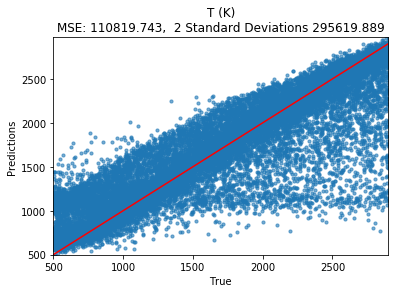

R2:  0.6309068488753021


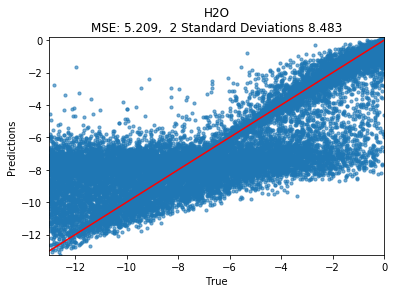

R2:  0.48839841802784256


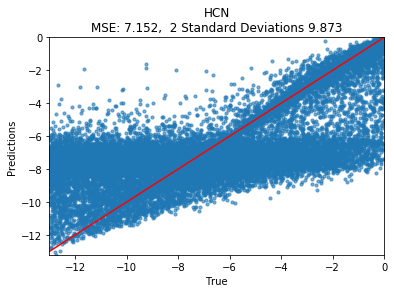

R2:  0.7239370916161307


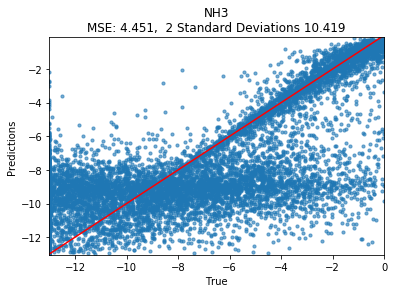

R2:  0.750938961181078


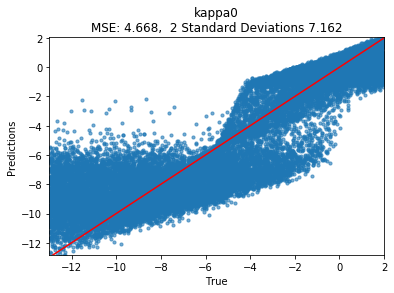

In [24]:
yyy = [-20,20] # This is just defining y = x
minx = np.min(y_data_test[:No_pred,:])
maxx = np.max(y_data_test[:No_pred,:])
miny = np.min(PRED.mean(1)[:,:])
maxy = np.max(PRED.mean(1)[:,:])
R2 =[]
for mol in range(y_data_tr.shape[-1]):
    plt.title(names[mol])
    plt.ylabel('Predictions')
    plt.xlabel('True')
    minx = np.min(y_data_test_un[:No_pred,mol])
    maxx = np.max(y_data_test_un[:No_pred,mol])
    miny = np.min(PRED_un_l.mean(0).mean(1)[:,mol])
    maxy = np.max(PRED_un_l.mean(0).mean(1)[:,mol])
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])
    plt.scatter(y_data_test_un[:No_pred,mol],PRED_un_l.mean(0).mean(1)[:,mol],s=10,alpha=0.6)
    yyy = [min(miny,minx),max(maxx,maxy)]
    plt.plot(yyy,yyy,'r')
    
#     print('For ',No_pred,' test planets:\n')
    # MSE: 
    MSE = np.mean((y_data_test_un[:No_pred,mol]  - PRED_un_l.mean(0).mean(1)[:,mol])**2)
    sig = np.std((y_data_test_un[:No_pred,mol]  - PRED_un_l.mean(0).mean(1)[:,mol])**2)
#     print(names[mol] + ' MSE: ',MSE, ' 2 Standard Deviations on MSE: ',2*sig)
    plt.title(names[mol] + '\nMSE: %.3f,  2 Standard Deviations %.3f' % (MSE,sig))
    R2.append(metrics.r2_score(y_data_test_un[:No_pred,mol], PRED_un_l.mean(0).mean(1)[:,mol]))
    print('R2: ',metrics.r2_score(y_data_test_un[:No_pred,mol], PRED_un_l.mean(0).mean(1)[:,mol]))
#     plt.savefig('./figures/test/ens_5_chol_loss_NN_validation'+names[mol]+'pred_vs_true.pdf')
    plt.show()

In [26]:
print(R2)

[0.7700341478425957, 0.6309068488753021, 0.48839841802784256, 0.7239370916161307, 0.750938961181078]


### Full test set gave:
[0.7704985116689018, 0.6291939776964828, 0.4908808986791091, 0.7229166199299755, 0.7512521357697245]

In [27]:
np.mean(R2)

0.6728430935085898

## Go back to original scale: (Un-normalise)

In [27]:
def tot_var(means,prec,n_samples):
    '''
    means: N_ensxNxD
    sigmas: N_ensxNxDxD
    '''
    N_ens, N, D = means.shape
    S = np.zeros((n_samples, D))
    m = np.mean(np.mean(means,1),0)
    I = np.eye(D) * (1/(N_ens))
#     prec = np.sum(np.mean(prec,1),0)
    sig = np.zeros((D,D))
    mu_comp =  np.zeros((D,))
    for n in range(N_ens):
        sig += np.linalg.inv(np.mean(prec,1)[n]) * (1/N_ens)
        mu_comp += (1/N_ens) * (np.mean(means,1)[n] - m) ** 2
#         prec = np.sum(np.mean(prec,1),0)
#     sig = np.linalg.inv(prec)
    sig_total =  mu_comp + sig
    for s in range(n_samples):
        S[s,:] = np.random.multivariate_normal(m,sig)
    return S,sig,m

A planet sample $p_s$ is drawn from a multivariate normal, where the parameters of the normal are the expected values from the output of a BNN. (Expectation over the posterior over the weights).

$$ p_s \sim \mathcal{N}(\mathrm{E}\left[\mu\right], \mathrm{E}\left[\Sigma\right]) $$

To unormalise: we must do $(\mu + m_{\mathrm{train}})/\sigma$ and $\mathrm{diag}(\sigma_{\mathrm{train}})\mathrm{E}\left[\Sigma\right]\mathrm{diag}(\sigma_{\mathrm{train}})$

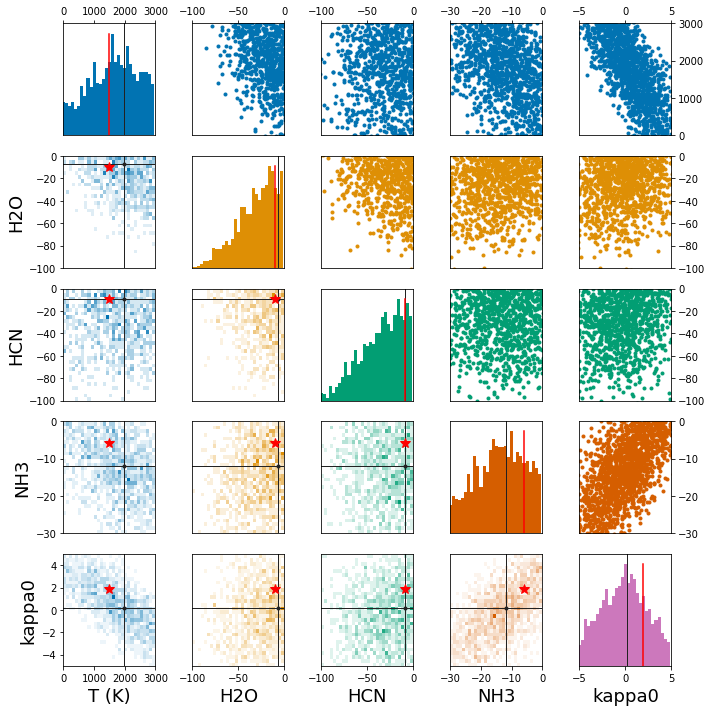

In [28]:
planet_id = 2; #101#50, 71, 11, 101, 50 51! 889! 0 is earth if in other cell -1 is selected

# If lATEX INSTALLED:
# names =  [r"\textbf{T (K)}", r"\textbf{H}$_2$\textbf{O}", r"\textbf{HCN}", r"\textbf{NH}$_3$", r"$\kappa_0$"]
# ELSE
names =  ["T (K)", "H2O", "HCN", "NH3", "kappa0"]
colors = ["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC"]

ranges=[[x, y] for x, y in zip(y_data_test_un.min(0), y_data_test_un.max(0))]

S_re_l,s,m = tot_var(PRED_un_l[:,planet_id],PREC_un_l[:,planet_id],n_samples=2000)
S_re_l = np.array(S_re_l).reshape((-1,5))
# ranges=[[x, y] for x, y in zip(S_re_l.min(0), S_re_l.max(0))]

ranges =  [[0, 3000], [-100, 0], [-100, 0], [-30, 0], [-5, 5]]
plan_net.posterior_matrix(S_re_l, y_data_test_un[planet_id,:num_features], names, ranges, colors, soft_colors=None)

plt.tight_layout()
# plt.savefig('./figures/test/ens_5/ens_5_planet'+str(planet_id)+'scaled.pdf')
plt.show()

### Mean Correlation accross all planets

In [29]:
mean_s = np.zeros((D,D))
for n in range(PRED_un_l.shape[1]):
    S_re_l,s,m = tot_var(PRED_un_l[:,n],PREC_un_l[:,n],n_samples=1)
    mean_s += s
print(mean_s/PRED_un_l.shape[1])

[[ 2.84723720e+06 -2.23648103e+04 -7.57044761e+03 -1.43922623e+04
  -1.43058145e+03]
 [-2.23648103e+04  6.34080077e+02  6.42699658e+00  6.79116208e+01
   7.41828510e+00]
 [-7.57044761e+03  6.42699658e+00  9.07066571e+02 -6.79378006e+00
   3.07562164e+01]
 [-1.43922623e+04  6.79116208e+01 -6.79378006e+00  2.05966634e+02
   1.56481144e+01]
 [-1.43058145e+03  7.41828510e+00  3.07562164e+01  1.56481144e+01
   7.03669373e+01]]


* Print sqrt diagonal (marginalised std)

In [30]:
np.sqrt(np.diag(mean_s/PRED_un_l.shape[1]))

array([1687.37583333,   25.1809467 ,   30.1175459 ,   14.35153769,
          8.3885003 ])

## WASP:

In [31]:
x_data_wasp = np.load('../data/WASP12b.npy')
x_data_wasp = (x_data_wasp - x_data.mean(0))/x_data.std(0)

In [32]:
PRED_un_wasp_l = []
PREC_un_wasp_l = []
for n in range(N_ensemble):
    weights_file_std = './ens_folder_models/ensemble_'+str(n)+'_check_point_weights_het_loss.h5'
    bnn.model.load_weights(weights_file_std)
    y_wasp_pred = np.array([bnn.model.predict(x_data_wasp.reshape((1,-1))) for _ in range(T)]).squeeze()
    PRED_un_wasp = y_wasp_pred[:,:D] * y_data.std(0)[:num_features] + y_data.mean(0)[:num_features]
    S_inv, chols = chol(y_wasp_pred[None,:,D:],D)
    PREC_un_wasp = np.matmul(np.diag(y_data.std(0)[:num_features]**-1),np.matmul(S_inv ,np.diag(y_data.std(0)[:num_features]**-1)))
    PRED_un_wasp_l.append(PRED_un_wasp)
    PREC_un_wasp_l.append(PREC_un_wasp)
    
PRED_un_wasp_l = np.array(PRED_un_wasp_l)
PREC_un_wasp_l = np.array(PREC_un_wasp_l)

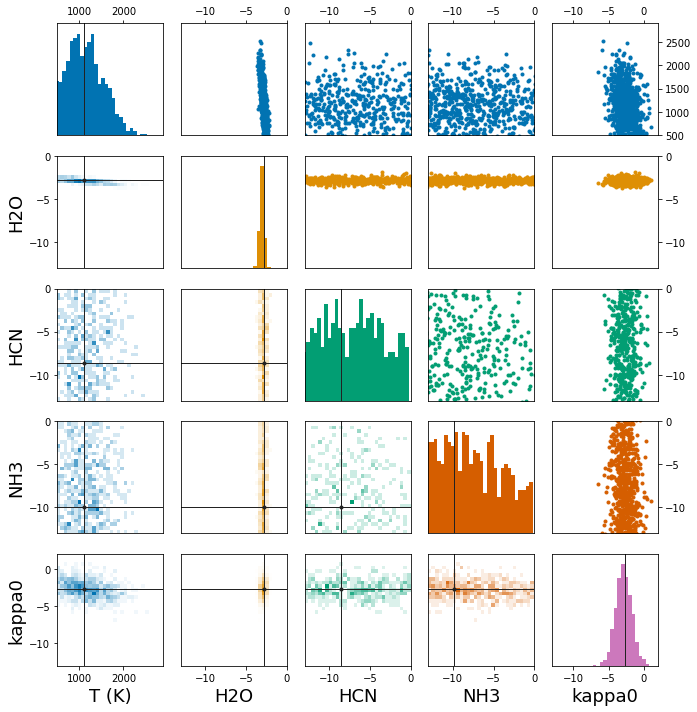

In [33]:
# names =  [r"\textbf{T (K)}", r"\textbf{H}$_2$\textbf{O}", r"\textbf{HCN}", r"\textbf{NH}$_3$", r"$\kappa_0$"]
ranges =  [[0, 3000], [-5, 0], [-13, 0], [-13, 0], [-13, 0]],
colors = ["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC"]
num_features = 12

ranges=[[x, y] for x, y in zip(y_data_test_un.min(0), y_data_test_un.max(0))]

S_re_l,s,m = tot_var(PRED_un_wasp_l,PREC_un_wasp_l[:,0],n_samples=1000)
S_re_l = np.array(S_re_l).reshape((-1,5))

plan_net.posterior_matrix(S_re_l, None, names, ranges, colors, soft_colors=None)

plt.tight_layout()
# plt.savefig('./figures/test/BNN_het_chol_loss_WASP_ens_5_1000_samples.pdf')
plt.show()

In [34]:
np.mean(S_re_l,0)

array([1123.13153201,   -2.84131755,   -8.48919768,   -9.86271301,
         -2.60905904])

In [35]:
np.std(S_re_l,0)

array([4.50414034e+02, 2.59624521e-01, 1.18233647e+01, 6.97590692e+00,
       1.13447959e+00])

In [25]:
np.save('test_predictions_cholesky_model_ensemble_5.npy',PRED)